# Takagi - Taupin equations for thin film systems
This notebook implements the 1D solution to the Takagi - Taupin equations relevant for thin film and multilayer systems. The film/multilayer is divided in a number of lamellas each having distinct, but fixed, compostion/strain/disorder. The scattering from the ensemble is computed iteratively starting from the film-substrate interface. The X-ray amplitude ratio $X_{n+1}$ at the top of a layer is related to the amplitude ratio at the bottom, $X_n$, by :
$$ X_{n+1} = \eta + \left( \eta^2 - 1 \right)^{1 / 2} {S_1 + S_2 \over S_1 - S_2}$$
with
    $$ S_1 = \left[X_n - \eta + \left(\eta ^2 -1 \right)^{1/2} \right] \exp \left[ - i T \left(\eta ^2 -1 \right)^{1/2} \right]$$
      $$ S_2 = \left[X_n - \eta - \left(\eta ^2 -1 \right)^{1/2} \right] \exp \left[ i T \left(\eta ^2 -1 \right)^{1/2} \right]$$


$\eta$ is dynamical theory's deviation parameter and $T$ is related the lamella thickness. The reader is referred to [this article](https://doi.org/10.1107/S0108767386098768) for more details.

In [1]:
import math
import cmath
import numpy as np
import numba as nb
import numexpr as ne
import matplotlib.pyplot as plt
import os
n_cpu = os.cpu_count()

In order to limit external dependencies some parameters have been pre-computed (structure factors) and/or are loaded from text files (strain / disorder profiles and instrumental resolution). A complete implemention without these limitations can be foud [here](https://aboulle.github.io/RaDMaX/).

In [2]:
#Material and experimental parameters
a = 5.1454 #Cubic lattice parameter
h, k, l = 0, 0, 4 #Miller indices
wl =  1.5406 #X-ray wavelength
bkg = 1e-5 #Diffractometer background
FH = 120.086339116+9.38660892172j#Structure Factor of hkl
FmH = 120.086339116+9.38660892172j#Structure Factor of -h-k-l
F0 = 223.616451004+9.38660892172j#Structwure Factor of 000
#Load data files
tth, intensity_exp = np.loadtxt("Input_XRD.txt", unpack = True)
depth, strain, DW = np.loadtxt("Input_strain_DW.txt", unpack = True)
resol = np.loadtxt("Input_resolution.txt")

In [3]:
#Global variables computed from the above
th = tth*np.pi/360.
d = a / (h*h + k*k + l*l)**0.5 #Cubic lattice spacing
Vol = a**3 #Cubic volume
re = 2.818e-5 #Classical electron radius
G = re*wl*wl / (np.pi*Vol) #Gamma : Structure Factor <-> -Polarizability conversion
thB_S  = np.arcsin(wl / (2*d)) #Bragg angle
thB = thB_S - strain * np.tan(thB_S) #Strain-corrected Bragg angle
phi = 0. #Surface-to-lattice planes angle
g0 = np.sin(thB_S - phi) #Incident beam direction cosine gamma 0
gH = -np.sin(thB_S + phi) #Diffracted beam direction cosine gamma H
b_S = g0 / gH #Substrate asymmetry ratio
t = depth.max() #Film thickness
z = t - depth #Distance from interface
N = len(z) - 1 #Number of lamellas
t_l = t/N #Lamella thickness

## Pure python implementation

In [4]:
def TakagiTaupin_python(th):
    res = [0 for i in range(len(th))]
    eta = [0 for i in range(len(th))]
    sqrt_eta2 = [0 for i in range(len(th))]
    #Loop over abscissa
    for i, th_i in enumerate(th):
        #Substrate
        eta[i] = (-b_S*(th_i-thB_S)*cmath.sin(2*thB_S) - 0.5*G*F0*(1-b_S)) / (cmath.sqrt(abs(b_S)) * G * cmath.sqrt(FH*FmH))
        res[i] = (eta[i] - np.sign(eta[i].real)* cmath.sqrt(eta[i]*eta[i] - 1)) * cmath.sqrt(FH / FmH)
        #Film
        n = 1
        while (n<=N):
            g0 = cmath.sin(thB[n] - phi)
            gH = -cmath.sin(thB[n] + phi)
            b = g0 / gH
            T = math.pi * G * (cmath.sqrt(FH*FmH)) * t_l * DW[n]/ (wl * cmath.sqrt(abs(g0*gH)) )
            eta[i] = (-b*(th_i-thB[n])*cmath.sin(2*thB_S) - 0.5*G*F0*(1-b)) / (math.sqrt(abs(b)) * G * DW[n] * cmath.sqrt(FH*FmH))
            sqrt_eta2[i] = cmath.sqrt(eta[i]*eta[i] - 1)
            S1 = (res[i] - eta[i] + sqrt_eta2[i])*cmath.exp(-1j*T*sqrt_eta2[i])
            S2 = (res[i] - eta[i] - sqrt_eta2[i])*cmath.exp(1j*T*sqrt_eta2[i])
            res[i] = (eta[i] + sqrt_eta2[i] * ((S1+S2)/(S1-S2))) * cmath.sqrt(FH / FmH)
            n += 1
        res[i] = abs(res[i])**2
    return np.array(res)

ref_intensity = TakagiTaupin_python(th)
%timeit TakagiTaupin_python(th)

1 loop, best of 3: 724 ms per loop


<IPython.core.display.Javascript object>


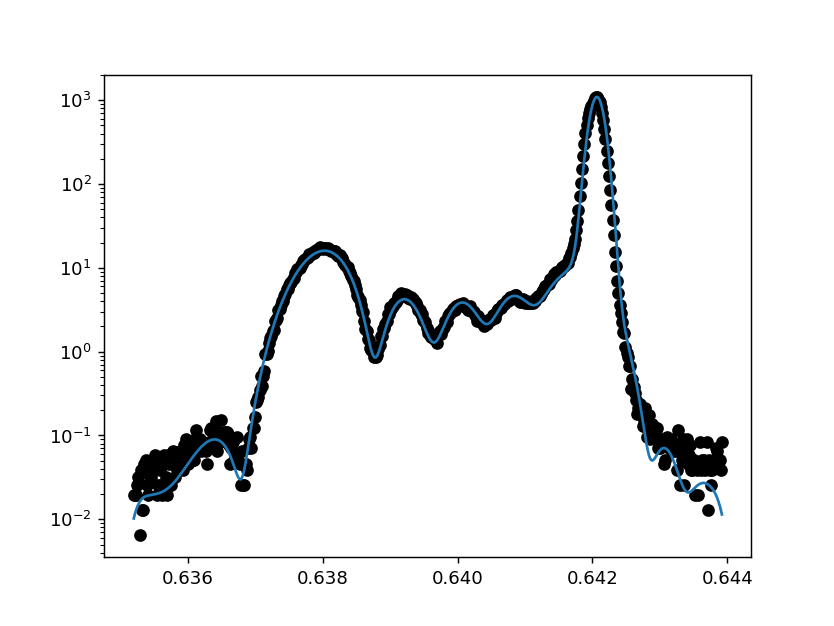

In [5]:
%matplotlib notebook
i_cal = TakagiTaupin_python(th)
i_cal = np.convolve(i_cal, resol, mode='same')
plt.semilogy(th, intensity_exp, 'ok', th, i_cal*intensity_exp.max()/i_cal.max())
plt.show()

## Numpy implementation

In [6]:
def TakagiTaupin_numpy(th):
    #Substrate
    eta = (-b_S*(th-thB_S)*np.sin(2*thB_S) - 0.5*G*F0*(1-b_S)) / ((abs(b_S)**0.5)*G*(FH*FmH)**0.5 )
    res = (eta - np.sign(eta.real)*((eta*eta - 1)**0.5)) * (FH / FmH)**0.5
    #Film
    n = 1
    while (n<=N):
        g0 = np.sin(thB[n] - phi)
        gH = -np.sin(thB[n] + phi)
        b = g0 / gH
        T = np.pi * G * ((FH*FmH)**0.5) * t_l * DW[n]/ (wl * (abs(g0*gH)**0.5) )
        eta = (-b*(th-thB[n])*np.sin(2*thB_S) - 0.5*G*F0*(1-b)) / ((abs(b)**0.5)*G*DW[n]*(FH*FmH)**0.5)
        sqrt_eta2 = (eta*eta-1)**0.5
        #cosx = np.cos(T*sqrt_eta2)
        #sinx = np.sin(T*sqrt_eta2)
        #S1 = (res - eta + sqrt_eta2)*(cosx - 1j*sinx)
        #S2 = (res - eta - sqrt_eta2)*(cosx + 1j*sinx) #precomputing the exp doesn't improve speed
        S1 = (res - eta + sqrt_eta2)*np.exp(-1j*T*sqrt_eta2)
        S2 = (res - eta - sqrt_eta2)*np.exp(1j*T*sqrt_eta2)
        
        res = (eta + sqrt_eta2*((S1+S2)/(S1-S2))) * (FH / FmH)**0.5
        n += 1
    return np.abs(res)**2

%timeit TakagiTaupin_numpy(th)
intensity = TakagiTaupin_numpy(th)
print("Error:", abs(intensity-ref_intensity).max()/ref_intensity.max())

10 loops, best of 3: 19.2 ms per loop
Error: 3.73460005796e-18


## Numexpr implementation

In [7]:
def TakagiTaupin_numexpr(th):
    ne.set_num_threads(8)
    #Substrate
    eta = ne.evaluate("(-b_S*(th-thB_S)*sin(2*thB_S) - 0.5*G*F0*(1-b_S)) / (sqrt(abs(b_S))*G*sqrt(FH*FmH))")
    res = ne.evaluate("(eta - (eta.real/abs(eta.real))*(sqrt(eta*eta - 1))) * sqrt(FH / FmH)")
    #Film
    n = 1
    pi = np.pi
    while (n<=N):
        g0 = np.sin(thB[n] - phi)
        gH = -np.sin(thB[n] + phi)
        b = g0 / gH
        DWn = DW[n]
        thBn = thB[n]
        T = ne.evaluate("pi*G*sqrt(FH*FmH)*t_l*DWn / (wl*sqrt(abs(g0*gH)))")
        eta = ne.evaluate("(-b*(th-thBn)*sin(2*thB_S) - 0.5*G*F0*(1-b)) / (sqrt(abs(b))*G*DWn*sqrt(FH*FmH))")
        sqrt_eta2 = ne.evaluate("sqrt(eta*eta-1)")
        S1 = ne.evaluate("(res - eta + sqrt_eta2)*exp(-1j*T*sqrt_eta2)")
        S2 = ne.evaluate("(res - eta - sqrt_eta2)*exp(1j*T*sqrt_eta2)")
        res = ne.evaluate("(eta + sqrt_eta2 * (S1+S2)/(S1-S2)) * sqrt(FH/FmH)")
        n += 1
    return ne.evaluate("res.real**2 + res.imag**2")

%timeit TakagiTaupin_numexpr(th)
intensity = TakagiTaupin_numexpr(th)
print("Error:", abs(intensity-ref_intensity).max()/ref_intensity.max())

10 loops, best of 3: 41.4 ms per loop
Error: 1.09492498339e-12


## Numba implementation

In [8]:
@nb.jit(nb.float64[:](nb.float64[:]), nopython=True, parallel=True, fastmath=True)
def TakagiTaupin_numba(th):
    res = np.zeros(len(th), dtype = np.complex128)
    eta = np.zeros(len(th), dtype = np.complex128)
    sqrt_eta2 = np.zeros(len(th), dtype = np.complex128)
    # loop over abscissa (parallelized)
    for i in nb.prange(len(th)):
        #Substrate
        eta[i] = (-b_S*(th[i]-thB_S)*cmath.sin(2*thB_S) - 0.5*G*F0*(1-b_S)) / (cmath.sqrt(abs(b_S)) * G * cmath.sqrt(FH*FmH) )
        res[i] = (eta[i] - np.sign(eta[i].real)*(cmath.sqrt(eta[i]*eta[i] - 1))) * cmath.sqrt(FH / FmH)
        #Film
        n = 1
        while (n<=N):
            g0 = cmath.sin(thB[n] - phi) ## gamma 0
            gH = -cmath.sin(thB[n] + phi) ## gamma H
            b = g0 / gH
            T = math.pi * G * (cmath.sqrt(FH*FmH)) * t_l * DW[n]/ (wl * cmath.sqrt(abs(g0*gH)) )
            eta[i] = (-b*(th[i]-thB[n])*cmath.sin(2*thB_S) - 0.5*G*F0*(1-b)) / (math.sqrt(abs(b)) * G * DW[n] * cmath.sqrt(FH*FmH))
            sqrt_eta2[i] = cmath.sqrt(eta[i]*eta[i] - 1)
            S1 = (res[i] - eta[i] + sqrt_eta2[i])*cmath.exp(-1j*T*sqrt_eta2[i])
            S2 = (res[i] - eta[i] - sqrt_eta2[i])*cmath.exp(1j*T*sqrt_eta2[i])
            res[i] = (eta[i] + (sqrt_eta2[i]) * ((S1+S2)/(S1-S2))) * cmath.sqrt(FH / FmH)
            n += 1
    return np.abs(res)**2

%timeit TakagiTaupin_numba(th)
intensity = TakagiTaupin_numba(th)
print("Error:", abs(intensity-ref_intensity).max()/ref_intensity.max())

100 loops, best of 3: 4.17 ms per loop
Error: 2.7255858143e-13


## Pythran implementation

In [9]:
%load_ext pythran.magic

In [10]:
#For some reason the arrays loaded from the text file with np.loadtxt and which have not been manipulated 
#need to be re-declared as ndarrays. Otherwise, pythran fails to recognize them.
DW = np.array(DW)

In [11]:
%%pythran -fopenmp
#pythran export TakagiTaupin_pythran(float[], float[], float[], float , int, float, float, complex, complex, complex, float, float, float)
import numpy as np

def TakagiTaupin_pythran(th, thB, DW, thB_S, N, t_l, G, F0, FH, FmH, b_S, phi, wl):
    res = np.zeros(len(th), dtype = np.complex128)
    eta = np.zeros(len(th), dtype = np.complex128)
    sqrt_eta2 = np.zeros(len(th), dtype = np.complex128)
    # loop over abscissa (parallelized)
    "omp parallel for"
    for i in range(len(th)):
        #Substrate
        eta[i] = (-b_S*(th[i]-thB_S)*np.sin(2*thB_S) - 0.5*G*F0*(1-b_S)) / (np.sqrt(abs(b_S)) * G * np.sqrt(FH*FmH) )
        res[i] = (eta[i] - np.sign(eta[i].real)*(np.sqrt(eta[i]*eta[i] - 1))) * np.sqrt(FH / FmH)
        #Film
        n = 1
        while (n<=N):
            g0 = np.sin(thB[n] - phi)
            gH = -np.sin(thB[n] + phi)
            b = g0 / gH
            T = np.pi * G * (np.sqrt(FH*FmH)) * t_l * DW[n]/ (wl * np.sqrt(abs(g0*gH)) )
            eta[i] = (-b*(th[i]-thB[n])*np.sin(2*thB_S) - 0.5*G*F0*(1-b)) / (np.sqrt(abs(b))*G*DW[n]*np.sqrt(FH*FmH))
            sqrt_eta2[i] = np.sqrt(eta[i]*eta[i] - 1)
            S1 = (res[i] - eta[i] + sqrt_eta2[i])*np.exp(-1j*T*sqrt_eta2[i])
            S2 = (res[i] - eta[i] - sqrt_eta2[i])*np.exp(1j*T*sqrt_eta2[i])
            res[i] = (eta[i] + (sqrt_eta2[i]) * ((S1+S2)/(S1-S2))) * np.sqrt(FH / FmH)
            n += 1
        res[i] = np.abs(res[i])**2
    return res

In [12]:
%timeit TakagiTaupin_pythran(th, thB, DW, thB_S, N, t_l, G, F0, FH, FmH, b_S, phi, wl)
intensity = TakagiTaupin_pythran(th, thB, DW.T, thB_S, N, t_l, G, F0, FH, FmH, b_S, phi, wl)
print("Error:", abs(intensity-ref_intensity).max()/ref_intensity.max())

The slowest run took 10.40 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 1.1 ms per loop
Error: 7.37956971452e-13


## Cython implementation

In [13]:
%load_ext Cython

In [14]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp
import numpy as np
from cython.parallel import prange
import cython

from libc.math cimport sin, sqrt, fabs

cdef extern from "complex.h" nogil:
    double complex cexp(double complex)
    double complex csqrt(double complex)
    double cabs(double complex)
    
@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
def TakagiTaupin_cython(double[::1] th, double[::1] thB, double[::1] DW, double thB_S,
                long N, double t_l, double G, double complex F0, double complex FH,
                double complex FmH, double b_S, double phi, double wl):
    cdef:
        double[::1] res_abs2
        double complex[::1] res, eta, sqrt_eta2
        double pi, b, g0, gH
        double complex T, S1, S2
        int n, size_th, i
        
    pi = np.pi
    size_th = th.size
    res = np.zeros(size_th , dtype=np.complex128)
    res_abs2 = np.zeros(size_th , dtype=np.float64)
    eta = np.zeros(size_th , dtype=np.complex128)
    sqrt_eta2 = np.zeros(size_th , dtype=np.complex128)

    # loop over abscissa (parallelized)
    for i in prange(size_th, nogil = True):
        #Substrate
        eta[i] = (-b_S*(th[i]-thB_S)*sin(2*thB_S) - 0.5*G*F0*(1-b_S)) / (sqrt(fabs(b_S)) * G * csqrt(FH*FmH) )
        res[i] = (eta[i] - (eta[i].real/fabs(eta[i].real))*(csqrt(eta[i]*eta[i] - 1))) * csqrt(FH / FmH)
        #Film
        n = 1
        while (n <= N):
            g0 = sin(thB[n] - phi)
            gH = -sin(thB[n] + phi)
            b = g0 / gH
            T = pi * G * (csqrt(FH*FmH)) * t_l * DW[n]/ (wl * csqrt(fabs(g0*gH)) )
            eta[i] = (-b*(th[i]-thB[n])*sin(2*thB_S) - 0.5*G*F0*(1-b)) / (sqrt(fabs(b))*G*DW[n]*csqrt(FH*FmH))
            sqrt_eta2[i] = csqrt(eta[i]*eta[i] - 1)
            S1 = (res[i] - eta[i] + sqrt_eta2[i])*cexp(-1j*T*sqrt_eta2[i])
            S2 = (res[i] - eta[i] - sqrt_eta2[i])*cexp(1j*T*sqrt_eta2[i])
            res[i] = (eta[i] + (sqrt_eta2[i]) * ((S1+S2)/(S1-S2))) * csqrt(FH / FmH)
            n = n + 1
        res_abs2[i] = cabs(res[i])**2
    return res_abs2

In [15]:
%timeit TakagiTaupin_cython(th, thB, DW, thB_S, N, t_l, G, F0, FH, FmH, b_S, phi, wl)
intensity = TakagiTaupin_cython(th, thB, DW, thB_S, N, t_l, G, F0, FH, FmH, b_S, phi, wl)
print("Error:", abs(intensity-ref_intensity).max()//ref_intensity.max())

The slowest run took 16.67 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 871 µs per loop
Error: 0.0
